In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import seaborn as sns
import statsmodels.api as sm
import os
import sys
import pathlib
import matplotlib.pyplot as plt
from tqdm import tqdm,trange
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix
import optuna
import shap
import joblib

from Code.utils import feature_engineering as fe
from Code.utils import xgb_helperfunc as xgb_hf
from Code.utils import visualization_utils as vis_utils
from Code.utils import MLAM as mlam

# 设置随机种子确保结果可重复
RANDOM_SEED = 2025
np.random.seed(RANDOM_SEED)
shap.plots.initjs()

# ==================================================
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import plot
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from typing import Optional, List, Union
# ==================================================

In [2]:
# 读取hs300 指数
hs300_index = pd.read_csv("..\\..\\Data\\hs300_Index.csv",index_col = 0, parse_dates = ['trade_day'])
# hs300 趋势
trend_span  = np.arange(10,30 + 1) # 向前看10 - 30个交易日
hs300_trend_result = mlam.getTrendLabel(price_series = hs300_index.close,l_span = trend_span)
hs300_close_trend = mlam.get_trend_label_for_plotting(hs300_index.close,hs300_trend_result) # 将趋势和价格序列合并
hs300_close_trend_plot = hs300_close_trend.dropna() # 画图的去处空值

# visualize
# plt.figure(figsize=(14,6))
# cmap = plt.cm.bwr
# sns.scatterplot(data=hs300_close_trend_plot, 
#                 x='trade_day', 
#                 y='close',
#                 hue='normed_t_value',  # Use the continuous values directly
#                 palette=cmap,
#                 legend=False)
# plt.show()

# plotly可视化
vis_utils.plot_trend_scatter(df = hs300_close_trend_plot.reset_index(),title = '沪深300趋势图', auto_open = False)

100%|██████████| 3681/3681 [00:35<00:00, 102.72it/s]


In [3]:
# hs300 收益率
hs300_X = hs300_index.copy()
hs300_X['intra_rtn'] = hs300_X['close'] / hs300_X['open'] - 1 # 日内收益率
hs300_X['overnight_rtn'] = hs300_X['open'] / hs300_X['close'].shift(1) - 1 # 隔夜
hs300_X['close_rtn'] = hs300_X['close'].pct_change() # 收盘价
hs300_X = hs300_X.dropna()
# 创建特征
hs300_X_short = fe.mom_cumrtn_and_sharpe(data_df = hs300_X, start = 10, end = 30, step = 5, ex_K = None, rtn_is_log = False)
hs300_X_medium = fe.mom_cumrtn_and_sharpe(data_df = hs300_X, start = 35, end = 90, step = 5, ex_K = 5, rtn_is_log = False)
hs300_X_long = fe.mom_cumrtn_and_sharpe(data_df = hs300_X, start = 95, end = 245, step = 5, ex_K = 20, rtn_is_log = False)

In [ ]:
hs300_y = hs300_close_trend[['t_value']].dropna()

hs300_X_short_shift1 = hs300_X_short.shift(1)
hs300_X_medium_shift1 = hs300_X_medium.shift(1)
hs300_X_long_shift1 = hs300_X_long.shift(1)

# 训练以及验证集的划分
# y label
y = hs300_close_trend[['t_value']].dropna()

# 训练(以及验证)集 和 测试集 划分
X_short_trainval, X_short_test, y_short_train, y_short_test = xgb_hf.prepare_train_test_data(hs300_X_short_shift1, y)
X_medium_trainval, X_medium_test, y_medium_train, y_medium_test = xgb_hf.prepare_train_test_data(hs300_X_medium_shift1, y)
X_long_trainval, X_long_test, y_long_train, y_long_test = xgb_hf.prepare_train_test_data(hs300_X_long_shift1, y)

# 训练集 和 验证集 划分
X_short_train, X_short_val, y_short_train, y_short_val = xgb_hf.prepare_train_val_data_bydate(X_short_trainval, y_short_train, val_date='random',exclude_monday = True)
X_medium_train, X_medium_val, y_medium_train, y_medium_val = xgb_hf.prepare_train_val_data_bydate(X_medium_trainval, y_medium_train, val_date='random',exclude_monday = True)
X_long_train, X_long_val, y_long_train, y_long_val = xgb_hf.prepare_train_val_data_bydate(X_long_trainval, y_long_train, val_date='random',exclude_monday = True)

# 准备DMatrix
# 短期
dtrain_short = xgb_hf.prepare_dmatrix(X_short_train, y_short_train)
dval_short = xgb_hf.prepare_dmatrix(X_short_val, y_short_val)
dtest_short = xgb_hf.prepare_dmatrix(X_short_test, y_short_test)
# 中期
dtrain_medium = xgb_hf.prepare_dmatrix(X_medium_train, y_medium_train) 
dval_medium = xgb_hf.prepare_dmatrix(X_medium_val, y_medium_val)
dtest_medium = xgb_hf.prepare_dmatrix(X_medium_test, y_medium_test)
# 长期
dtrain_long = xgb_hf.prepare_dmatrix(X_long_train, y_long_train)
dval_long = xgb_hf.prepare_dmatrix(X_long_val, y_long_val)
dtest_long = xgb_hf.prepare_dmatrix(X_long_test, y_long_test)


train: sample num: 2328
val: sample num: 584
test: sample num: 682


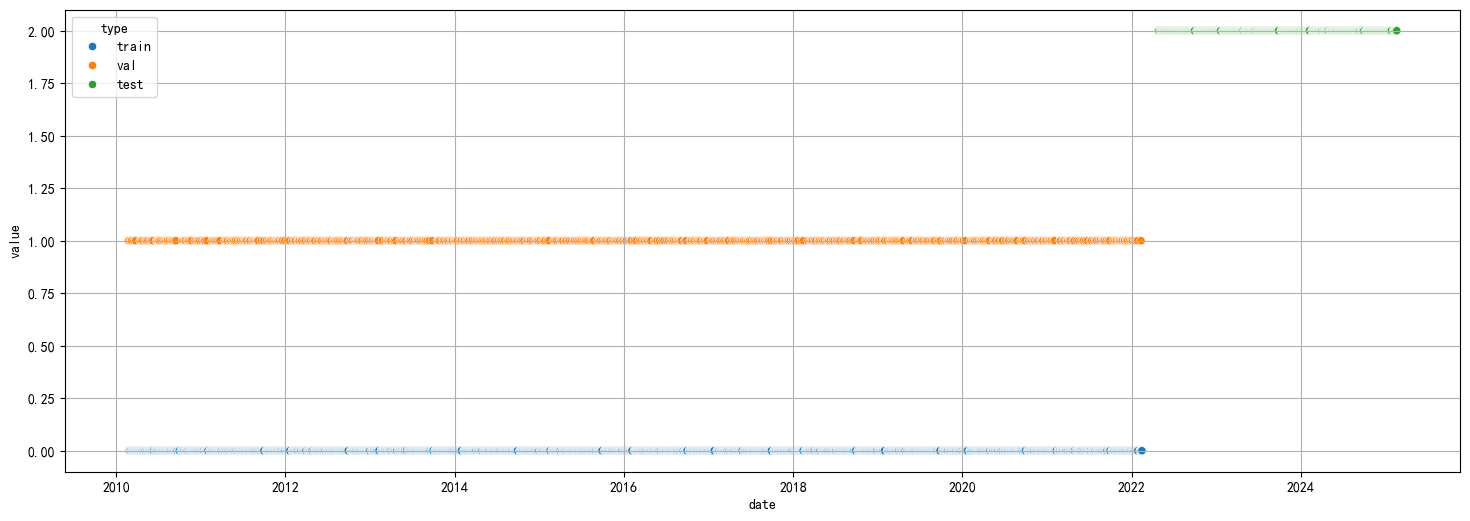

In [7]:
# 可视化 训练集 和 验证集 和 测试集
visual_data_df = xgb_hf.visual_set(train = y_short_train, val = y_short_val, test = y_long_test)

In [12]:
# Optuna 调参 + 训练模型
TODAY = datetime.now().strftime('%Y-%m-%d')
MODEL_SAVE_PTH = f'Output\\xgboost_models\\{TODAY}'
os.makedirs(MODEL_SAVE_PTH,exist_ok = True)

SHORT_TERM_MODEL_SAVE_PTH = f'{MODEL_SAVE_PTH}\\xgboost_short_term_model.json'
# short_best_params,short_best_num_round,short_best_score = xgb_helperfunc.optimize_hyperparameters(dtrain = dtrain_short, dval = dval_short, n_trials = 50, verbose_eval = 100)
# short_best_params_model,short_evals_result = xgb_helperfunc.train_with_best_params(short_best_params,short_best_num_round,dtrain = dtrain_short, dval = dval_short)
# short_best_params_model.save_model(SHORT_TERM_MODEL_SAVE_PTH)
# 读取短期模型
short_best_params_model = xgb.Booster() 
short_best_params_model.load_model(SHORT_TERM_MODEL_SAVE_PTH)
short_y_pred = short_best_params_model.predict(dtest_short) # 预测值
short_pred_df = xgb_helperfunc.concat_pred_to_test(short_y_pred,y_short_test) # 合并预测值与真实值


# 中期特征模型训练与预测
# Optuna 调参 + 训练模型 (中期特征)
MEDIUM_TERM_MODEL_SAVE_PTH = f'{MODEL_SAVE_PTH}\\xgboost_medium_term_model.json'
# medium_best_params,medium_best_num_round,medium_best_score = xgb_helperfunc.optimize_hyperparameters(dtrain = dtrain_medium, dval = dval_medium, n_trials = 50,verbose_eval = 100)
# medium_best_params_model,medium_evals_result = xgb_helperfunc.train_with_best_params(medium_best_params,medium_best_num_round,dtrain = dtrain_medium, dval = dval_medium)
# medium_best_params_model.save_model(MEDIUM_TERM_MODEL_SAVE_PTH)
# 读取中期模型
medium_best_params_model = xgb.Booster()
medium_best_params_model.load_model(MEDIUM_TERM_MODEL_SAVE_PTH)
medium_y_pred = medium_best_params_model.predict(dtest_medium) # 预测值
medium_pred_df = xgb_helperfunc.concat_pred_to_test(medium_y_pred,y_medium_test) # 合并预测值与真实值


# 长期特征模型训练与预测 
# Optuna 调参 + 训练模型 (长期特征)
LONG_TERM_MODEL_SAVE_PTH = f'{MODEL_SAVE_PTH}\\xgboost_long_term_model.json'
# long_best_params,long_best_num_round,long_best_score = xgb_helperfunc.optimize_hyperparameters(dtrain = dtrain_long, dval = dval_long, n_trials = 50,verbose_eval = 100)
# long_best_params_model,long_evals_result = xgb_helperfunc.train_with_best_params(long_best_params,long_best_num_round,dtrain = dtrain_long, dval = dval_long)
# long_best_params_model.save_model(LONG_TERM_MODEL_SAVE_PTH)
# 读取长期模型
long_best_params_model = xgb.Booster()
long_best_params_model.load_model(LONG_TERM_MODEL_SAVE_PTH)
long_y_pred = long_best_params_model.predict(dtest_long) # 预测值
long_pred_df = xgb_helperfunc.concat_pred_to_test(long_y_pred,y_long_test) # 合并预测值与真实值

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd5 in position 156: invalid continuation byte

In [ ]:
# 评估
import utils.visualization_utils as vis_utils
PRED_RESULT_SAVE_PTH = 'Output\\predict_output'
os.makedirs(PRED_RESULT_SAVE_PTH,exist_ok = True)

# 评估短期模型
short_hs300_close_test_period = hs300_close_trend.loc[y_short_test.index,'close']
short_hs300_close_test_period /= short_hs300_close_test_period.values[0]  # 归一化价格

# 执行评估并打印结果
short_term_metrics = vis_utils.evaluate_model_performance(y_true = short_pred_df['test_sign'].values, y_pred = short_pred_df['pred_sign'].values, show_heatmap = True)
short_term_metrics_df = pd.DataFrame.from_dict(short_term_metrics, orient = 'index', columns = ['Value'])


# 创建交互式可视化
_ = vis_utils.create_interactive_plot(
    price_series=short_hs300_close_test_period, 
    pred_df=short_pred_df, 
    title='沪深300指数短期预测信号可视化',
    save = True,
    save_path = f'{PRED_RESULT_SAVE_PTH}\\short_term_interactive_plot.html',
    auto_open = True
)

# 创建子图可视化
_ = vis_utils.create_subplot_visualization(
    price_series=short_hs300_close_test_period, 
    pred_df=short_pred_df,
    title='沪深300指数短期预测真实值与预测值对比',
    save = True,
    save_path = f'{PRED_RESULT_SAVE_PTH}\\short_term_subplot_visualization.html',
    auto_open = True
)


# 中期特征模型评估代码 (已注释)
mid_hs300_close_test_period = hs300_close_trend.loc[y_medium_test.index,'close']
mid_hs300_close_test_period /= mid_hs300_close_test_period.values[0]  # 归一化价格

mid_term_metrics = vis_utils.evaluate_model_performance(y_true = medium_pred_df['test_sign'].values, y_pred = medium_pred_df['pred_sign'].values, show_heatmap = True)
mid_term_metrics_df = pd.DataFrame.from_dict(mid_term_metrics, orient = 'index', columns = ['Value'])

_ = vis_utils.create_interactive_plot(
    price_series=mid_hs300_close_test_period, 
    pred_df=medium_pred_df, 
    title='沪深300指数中期预测信号可视化',
    save = True,
    save_path = f'{PRED_RESULT_SAVE_PTH}\\medium_term_interactive_plot.html',
    auto_open = True
)
_ = vis_utils.create_subplot_visualization(
    price_series=mid_hs300_close_test_period, 
    pred_df=medium_pred_df,
    title='沪深300指数中期预测真实值与预测值对比',
    save = True,
    save_path = f'{PRED_RESULT_SAVE_PTH}\\medium_term_subplot_visualization.html',
    auto_open = True
)



# 长期特征模型评估代码 
long_hs300_close_test_period = hs300_close_trend.loc[y_long_test.index,'close'] 
long_hs300_close_test_period /= long_hs300_close_test_period.values[0]  # 归一化价格

long_term_metrics = vis_utils.evaluate_model_performance(y_true = long_pred_df['test_sign'].values, y_pred = long_pred_df['pred_sign'].values, show_heatmap = True)
long_term_metrics_df = pd.DataFrame.from_dict(long_term_metrics, orient = 'index', columns = ['Value'])

_ = vis_utils.create_interactive_plot(
    price_series=long_hs300_close_test_period, 
    pred_df=long_pred_df, 
    title='沪深300指数长期预测信号可视化',
    save = True,
    save_path = f'{PRED_RESULT_SAVE_PTH}\\long_term_interactive_plot.html',
    auto_open = True
)
_ = vis_utils.create_subplot_visualization(
    price_series=long_hs300_close_test_period, 
    pred_df=long_pred_df,
    title='沪深300指数长期预测真实值与预测值对比',
    save = True,
    save_path = f'{PRED_RESULT_SAVE_PTH}\\long_term_subplot_visualization.html',
    auto_open = True
)


In [ ]:
# 初始化SHAP解释器
short_SHAP_explainer = shap.TreeExplainer(short_best_params_model)
medium_SHAP_explainer = shap.TreeExplainer(medium_best_params_model)
long_SHAP_explainer = shap.TreeExplainer(long_best_params_model)

# 计算SHAP值
short_shap_values_train = short_SHAP_explainer.shap_values(X = X_short_train, y = y_short_train)
short_shap_values_test = short_SHAP_explainer.shap_values(X = X_short_test, y = y_short_test)
short_expected_value = float(short_SHAP_explainer.expected_value) # SHAP基准值
print(f"短期模型SHAP基准值: {short_expected_value}")


medium_shap_values_train = medium_SHAP_explainer.shap_values(X = X_medium_train, y = y_medium_train)
medium_shap_values_test = medium_SHAP_explainer.shap_values(X = X_medium_test, y = y_medium_test)
medium_expected_value = float(medium_SHAP_explainer.expected_value)
print(f"中期模型SHAP基准值: {medium_expected_value}")

long_shap_values_train = long_SHAP_explainer.shap_values(X = X_long_train, y = y_long_train)
long_shap_values_test = long_SHAP_explainer.shap_values(X = X_long_test, y = y_long_test)
long_expected_value = float(long_SHAP_explainer.expected_value)
print(f"长期模型SHAP基准值: {long_expected_value}")


In [ ]:
# =============================================
# SHAP: 条形图摘要
# =============================================
short_feature_importance = pd.DataFrame(index = X_short_test.columns, data = np.abs(short_shap_values_test).mean(axis = 0),columns = ['importance']).sort_values(by = 'importance', ascending = False)
# display(short_feature_importance)
plt.figure()
shap.summary_plot(short_shap_values_test, X_short_test, plot_type="bar", feature_names=X_short_test.columns, show=False)
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.title("SHAP 特征重要性")
plt.tight_layout()
plt.show()

print("生成了SHAP特征重要性图，就是每个特征的平均绝对SHAP值")
print("解读特征重要性图:")
print("- 条形图展示了每个特征的平均绝对SHAP值")
print("- 最重要的特征在顶部")

In [ ]:
# =============================================
# SHAP: 摘要图
# =============================================
plt.figure()
shap.summary_plot(short_shap_values_test, X_short_test, feature_names=X_short_test.columns, show=False)
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.title("SHAP 摘要图")
plt.tight_layout()
plt.show()

print("- 每一行代表一个特征")
print("- 横轴是SHAP值，表示特征对预测的影响程度")
print("- 点的颜色表示特征值的大小（红色大，蓝色小）")
print("- 特征按照重要性排序")


In [ ]:
# =============================================
# SHAP: Force Plot(单个样本)
# =============================================

# sample_idx = 0
# sample_date = X_short_test.index[sample_idx].strftime('%Y-%m-%d')
# true_value = y_short_test.iloc[sample_idx]  # 获取真实值

# # 绘制force plot
# shap_plot = shap.plots.force(
#     base_value = short_expected_value,
#     shap_values = short_shap_values_test[sample_idx],
#     features = X_short_test.iloc[sample_idx].round(4),
#     feature_names = X_short_test.columns,
#     matplotlib = True,
#     show = False
# )

# # 获取当前图形
# fig = plt.gcf()
# # 设置图形大小
# fig.set_size_inches(20, 6)
# # 调整标题位置和内容，包含真实值
# plt.title(f"短期模型力图: {sample_date} | 真实值: {true_value:.4f}, 预测值: {short_y_pred[sample_idx]:.4f}", pad=15, fontsize=14, y = 1.5)
# # 调整布局并显示
# plt.tight_layout()
# plt.show()

# 创建样本力图(static)
# sample_date_idx = X_short_test.index.get_loc('2025-02-12')
sample_idx = -1
sample_date = X_short_test.index[sample_idx].strftime('%Y-%m-%d')
true_value = y_short_test.iloc[sample_idx]

# 使用新的自定义函数绘制SHAP力图
fig = vis_utils.plot_custom_shap_force(
    base_value=short_expected_value,
    shap_values=short_shap_values_test[sample_idx],
    features=X_short_test.iloc[sample_idx],
    feature_names=X_short_test.columns,
    true_value=true_value,
    pred_value=short_y_pred[sample_idx],
    sample_date=sample_date,
    top_features_num=10,  # 显示前10个重要特征
    shap_decimals=2,      # SHAP值显示2位小数
    pred_decimals=4,      # 预测值显示4位小数
    figsize=(14, 8)       # 自定义图形大小
)

plt.show()

# 创建样本力图(interactive)
interactive_force_fig = vis_utils.plot_interactive_shap_force(
    base_value=short_expected_value,
    shap_values=short_shap_values_test[sample_idx],
    features=X_short_test.iloc[sample_idx],
    feature_names=X_short_test.columns,
    true_value=true_value,
    pred_value=short_y_pred[sample_idx],
    sample_date=sample_date,
    top_features_num=10,
    shap_decimals=2,
    pred_decimals=4,
    save=False,
    save_path=None,
    auto_open = True
)


In [27]:
# =============================================
# SHAP: Force Plot(整体)
# =============================================
from typing import Optional, List, Union
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import plot


def plot_period_shap_force(
    base_value: float,
    shap_values: np.ndarray,
    features: pd.DataFrame,
    feature_names: List[str] = None,
    y_true: Optional[np.ndarray] = None,
    y_pred: Optional[np.ndarray] = None,
    sample_start_index: int = 0,
    sample_end_index: Optional[int] = None,
    dates: Optional[List[str]] = None,
    top_features_num: int = 10,
    shap_decimals: int = 2,
    pred_decimals: int = 4,
    feature_decimals: int = 4,
    plot_width: int = 1200,
    plot_height: int = 800,
    pos_color: str = 'rgba(255, 0, 0, 0.7)',
    neg_color: str = 'rgba(0, 0, 255, 0.7)',
    save: bool = False,
    save_path: Optional[str] = None,
    auto_open: bool = False
) -> go.Figure:
    """
    创建特定时间段的SHAP力图，展示多个样本的SHAP值分布和贡献情况
    
    参数:
        base_value (float): 模型的基准预测值
        shap_values (np.ndarray): 所有样本的SHAP值数组，形状为(n_samples, n_features)
        features (pd.DataFrame): 特征数据框，形状为(n_samples, n_features)
        feature_names (List[str]): 特征名称列表，如果为None则使用features.columns
        y_true (np.ndarray, optional): 真实值数组
        y_pred (np.ndarray, optional): 预测值数组
        sample_start_index (int): 样本起始索引，默认为0
        sample_end_index (int, optional): 样本结束索引，如果为None则使用所有样本
        dates (List[str], optional): 日期列表，用于标注样本
        top_features_num (int): 要显示的最重要特征数量，默认10
        shap_decimals (int): SHAP值显示的小数位数，默认2
        pred_decimals (int): 预测值、真实值和基准值显示的小数位数，默认4
        feature_decimals (int): 特征值显示的小数位数，默认4
        plot_width (int): 图表宽度，默认1200
        plot_height (int): 图表高度，默认800
        pos_color (str): 正面贡献的颜色，默认红色
        neg_color (str): 负面贡献的颜色，默认蓝色
        save (bool): 是否保存图表为HTML文件
        save_path (str, optional): 保存路径
        auto_open (bool): 是否自动打开保存的HTML文件
        
    返回:
        go.Figure: Plotly图表对象
    """
    # 使用DataFrame的列名作为特征名称（如果未提供）
    if feature_names is None and isinstance(features, pd.DataFrame):
        feature_names = features.columns.tolist()
    
    # 计算每个特征的平均绝对SHAP值（全局重要性）
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=False)
    
    # 选择前N个最重要的特征
    top_features_idx = [feature_names.index(feat) for feat in feature_importance.head(top_features_num)['feature']]
    top_feature_names = feature_importance.head(top_features_num)['feature'].tolist()
    
    # 确定要展示的样本范围
    if sample_end_index is None:
        sample_end_index = shap_values.shape[0]
    
    # 确保索引范围有效
    sample_start_index = max(0, min(sample_start_index, shap_values.shape[0]-1))
    sample_end_index = max(sample_start_index+1, min(sample_end_index, shap_values.shape[0]))
    
    # 生成样本索引列表
    sample_indices = list(range(sample_start_index, sample_end_index))
    
    # 创建子图布局
    fig = sp.make_subplots(
        rows=2, cols=1,
        row_heights=[0.3, 0.7],
        vertical_spacing=0.1,
        subplot_titles=('预测值与真实值分布', 'SHAP值分布 (按特征)')
    )
    
    # 第一个子图：预测值与真实值的散点图（如果提供）
    if y_pred is not None:
        sample_texts = []
        for i in sample_indices:
            if dates is not None and i < len(dates):
                sample_texts.append(f"样本 {i}<br>日期: {dates[i]}<br>预测值: {y_pred[i]:.{pred_decimals}f}")
            else:
                sample_texts.append(f"样本 {i}<br>预测值: {y_pred[i]:.{pred_decimals}f}")
        
        fig.add_trace(
            go.Scatter(
                x=list(range(len(sample_indices))),
                y=[y_pred[i] for i in sample_indices],
                mode='markers',
                name='预测值',
                marker=dict(
                    size=10,
                    color='blue',
                    symbol='circle'
                ),
                hoverinfo='text',
                hovertext=sample_texts
            ),
            row=1, col=1
        )
        
        # 添加基准值线
        fig.add_shape(
            type="line",
            x0=0, y0=base_value, x1=len(sample_indices)-1, y1=base_value,
            line=dict(color="gray", width=2, dash="dash"),
            row=1, col=1
        )
        
        # 添加基准值标注
        fig.add_annotation(
            x=len(sample_indices)-1,
            y=base_value,
            text=f"基准值: {base_value:.{pred_decimals}f}",
            showarrow=True,
            arrowhead=1,
            ax=30,
            ay=0,
            row=1, col=1
        )
        
        if y_true is not None:
            # 为每个真实值点创建hover文本
            true_hover_texts = []
            for i in sample_indices:
                if dates is not None and i < len(dates):
                    true_hover_texts.append(f"样本 {i}<br>日期: {dates[i]}<br>真实值: {y_true[i]:.{pred_decimals}f}")
                else:
                    true_hover_texts.append(f"样本 {i}<br>真实值: {y_true[i]:.{pred_decimals}f}")
                
            fig.add_trace(
                go.Scatter(
                    x=list(range(len(sample_indices))),
                    y=[y_true[i] for i in sample_indices],
                    mode='markers',
                    name='真实值',
                    marker=dict(
                        size=10,
                        color='red',
                        symbol='cross'
                    ),
                    hoverinfo='text',
                    hovertext=true_hover_texts
                ),
                row=1, col=1
            )
    
    # 第二个子图：SHAP值分布图
    for i, feature_idx in enumerate(top_features_idx):
        feature_name = top_feature_names[i]
        
        # 所有样本在该特征上的SHAP值
        feature_shap_values = [shap_values[idx, feature_idx] for idx in sample_indices]
        
        # 添加每个样本在该特征上的SHAP值散点
        hover_texts = []
        for j, sample_idx in enumerate(sample_indices):
            shap_value = shap_values[sample_idx, feature_idx]
            feature_value = features.iloc[sample_idx, feature_idx] if isinstance(features, pd.DataFrame) else features[sample_idx, feature_idx]
            
            if dates is not None and sample_idx < len(dates):
                hover_texts.append(f"样本 {sample_idx}<br>日期: {dates[sample_idx]}<br>特征: {feature_name}<br>特征值: {feature_value:.{feature_decimals}f}<br>SHAP值: {shap_value:.{shap_decimals}f}")
            else:
                hover_texts.append(f"样本 {sample_idx}<br>特征: {feature_name}<br>特征值: {feature_value:.{feature_decimals}f}<br>SHAP值: {shap_value:.{shap_decimals}f}")
        
        # 为每个特征使用不同颜色
        feature_color = 'rgba(' + ','.join([str(int(50 + 200 * i / len(top_features_idx))), 
                                          str(int(50 + 150 * (len(top_features_idx) - i) / len(top_features_idx))), 
                                          str(int(100 + 150 * i / len(top_features_idx)))] + ['0.7']) + ')'
        
        fig.add_trace(
            go.Box(
                y=[i] * len(feature_shap_values),
                x=feature_shap_values,
                name=feature_name,
                orientation='h',
                marker=dict(color=feature_color),
                boxpoints='all',
                jitter=0.5,
                pointpos=0,
                hoveron="points",
                hoverinfo='text',
                hovertext=hover_texts,
                # 调整点大小
                marker_size=8
            ),
            row=2, col=1
        )
    
    # 为基准值添加垂直线
    fig.add_shape(
        type="line",
        x0=0, y0=0, x1=0, y1=1,
        yref="paper",
        line=dict(color="black", width=1),
        row=2, col=1
    )
    
    # 添加Y轴标签（特征名称）
    fig.update_yaxes(
        tickvals=list(range(len(top_feature_names))),
        ticktext=top_feature_names,
        row=2, col=1
    )
    
    # 创建日期标签（如果提供）
    if dates is not None and len(dates) > 0:
        date_labels = []
        for i in sample_indices:
            if i < len(dates):
                date_labels.append(dates[i])
            else:
                date_labels.append(f"样本 {i}")
        
        # 更新X轴刻度标签为日期（每隔几个显示一个，避免拥挤）
        step = max(1, len(sample_indices) // 10)  # 最多显示约10个标签
        tick_vals = list(range(0, len(sample_indices), step))
        tick_text = [date_labels[i] for i in tick_vals]
        
        fig.update_xaxes(
            tickvals=tick_vals,
            ticktext=tick_text,
            tickangle=45,
            row=1, col=1
        )
    
    # 更新X和Y轴标题
    if y_pred is not None or y_true is not None:
        fig.update_xaxes(title_text="样本索引/日期", row=1, col=1)
        fig.update_yaxes(title_text="值", row=1, col=1)
    
    fig.update_xaxes(title_text="SHAP值", row=2, col=1)
    fig.update_yaxes(title_text="特征", row=2, col=1)
    
    # 构建标题
    period_info = ""
    if dates is not None and len(dates) > 0:
        if sample_start_index < len(dates) and sample_end_index-1 < len(dates):
            period_info = f"时间段: {dates[sample_start_index]} 至 {dates[sample_end_index-1]}"
    
    # 更新布局
    fig.update_layout(
        title=f"时期SHAP值分布{' | ' + period_info if period_info else ''}",
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        ),
        template="plotly_white",
        width=plot_width,
        height=plot_height,
        margin=dict(t=150, b=50, l=150, r=50),
        boxmode='group'
    )
    
    # 保存为HTML文件
    if save:
        if save_path:
            plot(fig, filename=save_path, auto_open=auto_open)
        else:
            raise ValueError('save_path is not provided')
    else:
        plot(fig, auto_open=auto_open)
    
    return fig

In [ ]:
# 准备日期列表（用于标注样本）
dates = X_short_test.index.strftime('%Y-%m-%d').tolist()

# 创建全局SHAP力图
period_force_fig = vis_utils.plot_period_shap_force(
    base_value=short_expected_value,
    shap_values=short_shap_values_test,  # 所有样本的SHAP值
    features=X_short_test,               # 所有样本的特征值
    feature_names=X_short_test.columns.tolist(),
    y_true=y_short_test.values,          # 真实值
    y_pred=short_y_pred,                 # 预测值
    dates=dates,                         # 日期标签
    top_features_num=10,                 # 展示前10个重要特征
    sample_start_index=0,                # 展示30个样本
    sample_end_index=30,
    # 可选：保存为HTML文件
    save=False,
    save_path= None,
    auto_open= True
)

In [50]:
def plot_global_shap_force(
    base_value: float,
    shap_values: np.ndarray,
    features: pd.DataFrame,
    feature_names: List[str] = None,
    y_true: Optional[np.ndarray] = None,
    y_pred: Optional[np.ndarray] = None,
    line_series: Optional[pd.Series] = None,
    dates: Optional[List[str]] = None,
    color_by: str = 'sign',  # 'sign' 或 'category'
    category_values: Optional[np.ndarray] = None,
    category_colors: Optional[dict] = None,
    top_features_num: int = 10,
    shap_decimals: int = 2,
    pred_decimals: int = 4,
    feature_decimals: int = 4,
    plot_width: int = 1800,
    plot_height: int = 1600,
    point_size: int = 6,
    save: bool = False,
    save_path: Optional[str] = None,
    auto_open: bool = False
) -> go.Figure:
    """
    创建全局SHAP力图，展示所有样本的预测值分布和贡献情况
    
    参数:
        base_value (float): 模型的基准预测值
        shap_values (np.ndarray): 所有样本的SHAP值数组，形状为(n_samples, n_features)
        features (pd.DataFrame): 特征数据框，形状为(n_samples, n_features)
        feature_names (List[str]): 特征名称列表，如果为None则使用features.columns
        y_true (np.ndarray, optional): 真实值数组
        y_pred (np.ndarray, optional): 预测值数组
        line_series (pd.Series, optional): 时间序列数据（如收盘价），索引应与dates对应
        dates (List[str], optional): 日期列表，用于标注样本
        color_by (str): 散点颜色依据，'sign'表示根据预测值正负，'category'表示根据类别
        category_values (np.ndarray, optional): 类别值数组，当color_by='category'时使用
        category_colors (dict, optional): 类别对应的颜色字典，如{0: 'blue', 1: 'red'}
        top_features_num (int): 要显示的最重要特征数量，默认10
        shap_decimals (int): SHAP值显示的小数位数，默认2
        pred_decimals (int): 预测值、真实值和基准值显示的小数位数，默认4
        feature_decimals (int): 特征值显示的小数位数，默认4
        plot_width (int): 图表宽度，默认1800
        plot_height (int): 图表高度，默认1600
        point_size (int): 散点大小，默认6
        save (bool): 是否保存图表为HTML文件
        save_path (str, optional): 保存路径
        auto_open (bool): 是否自动打开保存的HTML文件
        
    返回:
        go.Figure: Plotly图表对象
    """
    # 使用DataFrame的列名作为特征名称（如果未提供）
    if feature_names is None and isinstance(features, pd.DataFrame):
        feature_names = features.columns.tolist()
    
    # 检查color_by参数
    if color_by not in ['sign', 'category']:
        raise ValueError("color_by参数必须是'sign'或'category'")
    
    if color_by == 'category' and category_values is None:
        raise ValueError("当color_by='category'时，必须提供category_values参数")
    
    # 设置默认类别颜色
    if color_by == 'category' and category_colors is None:
        unique_categories = np.unique(category_values)
        category_colors = {}
        # 生成不同类别的颜色
        cmap = px.colors.qualitative.Plotly
        for i, cat in enumerate(unique_categories):
            category_colors[cat] = cmap[i % len(cmap)]
    
    # 计算每个特征的平均绝对SHAP值（全局重要性）
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_abs_shap
    }).sort_values('importance', ascending=False)
    
    # 选择前N个最重要的特征
    top_features = feature_importance.head(top_features_num)['feature'].tolist()
    top_features_idx = [feature_names.index(feat) for feat in top_features]
    
    # 确定样本索引
    sample_indices = list(range(shap_values.shape[0]))
    
    # 准备hover信息
    hover_texts = []
    for i in sample_indices:
        hover_text = ""
        if dates is not None and i < len(dates):
            hover_text += f"样本 {i}<br>日期: {dates[i]}<br>"
        else:
            hover_text += f"样本 {i}<br>"
            
        # 添加预测值和真实值
        if y_pred is not None:
            hover_text += f"预测值: {y_pred[i]:.{pred_decimals}f}<br>"
        if y_true is not None:
            hover_text += f"真实值: {y_true[i]:.{pred_decimals}f}<br>"
        
        hover_text += f"基准值: {base_value:.{pred_decimals}f}<br><br>"
        
        # 添加每个重要特征的值和SHAP贡献
        hover_text += "<b>特征贡献:</b><br>"
        for feat in top_features:
            feat_idx = feature_names.index(feat)
            feat_val = features.iloc[i, feat_idx] if isinstance(features, pd.DataFrame) else features[i, feat_idx]
            shap_val = shap_values[i, feat_idx]
            
            # 使用HTML格式化，为特征名称使用黑色，为正SHAP值使用红色，为负SHAP值使用蓝色
            color = "red" if shap_val > 0 else "blue"
            # 特征名黑色，值和SHAP彩色
            hover_text += f"<span style='color:black'>{feat}</span>: {feat_val:.{feature_decimals}f} | <span style='color:{color}'>SHAP: {shap_val:.{shap_decimals}f}</span><br>"
            
        hover_texts.append(hover_text)
    
    # 创建子图布局
    # 根据是否有line_series决定子图数量和布局
    if line_series is not None:
        fig = sp.make_subplots(
            rows=3, cols=1,
            row_heights=[0.4, 0.3, 0.3],
            vertical_spacing=0.08,
            subplot_titles=('时间序列与预测', '预测值与真实值分布', '预测值分布')
        )
    else:
        fig = sp.make_subplots(
            rows=2, cols=1,
            row_heights=[0.5, 0.5],
            vertical_spacing=0.1,
            subplot_titles=('预测值与真实值分布', '预测值分布')
        )
    
    # 如果提供了line_series，添加第一个子图
    if line_series is not None and dates is not None:
        # 确保line_series索引与dates一致
        if len(line_series) != len(dates):
            # 尝试将line_series重新索引到与dates相同的索引
            try:
                if isinstance(line_series.index, pd.DatetimeIndex):
                    # 将dates转换为日期时间索引
                    date_index = pd.DatetimeIndex(dates)
                    # 尝试重新索引line_series
                    line_series = line_series.reindex(date_index)
                else:
                    print("警告：line_series的索引与dates不匹配，可能导致绘图错误")
            except:
                print("警告：无法重新索引line_series，可能导致绘图错误")
        
        # 绘制时间序列线
        fig.add_trace(
            go.Scatter(
                x=list(range(len(dates))),
                y=line_series.values,
                mode='lines',
                name='时间序列',
                line=dict(color='gray', width=2),
            ),
            row=1, col=1
        )
        
        # 准备散点颜色
        if color_by == 'sign' and y_pred is not None:
            # 根据预测值的符号设置颜色
            colors = ['red' if pred > 0 else 'blue' for pred in y_pred]
        elif color_by == 'category' and category_values is not None:
            # 根据类别设置颜色
            colors = [category_colors.get(cat, 'gray') for cat in category_values]
        else:
            # 默认颜色
            colors = ['blue'] * len(sample_indices)
        
        # 添加预测值散点
        if y_pred is not None:
            fig.add_trace(
                go.Scatter(
                    x=list(range(len(sample_indices))),
                    y=line_series.values,
                    mode='markers',
                    marker=dict(
                        size=point_size,
                        color=colors,
                    ),
                    name='预测点',
                    hoverinfo='text',
                    hovertext=hover_texts
                ),
                row=1, col=1
            )
            
            # 添加图例项，显示不同颜色的含义
            if color_by == 'sign':
                # 添加正负图例
                fig.add_trace(
                    go.Scatter(
                        x=[None], y=[None],
                        mode='markers',
                        marker=dict(size=10, color='red'),
                        name='正值预测',
                        showlegend=True
                    ),
                    row=1, col=1
                )
                fig.add_trace(
                    go.Scatter(
                        x=[None], y=[None],
                        mode='markers',
                        marker=dict(size=10, color='blue'),
                        name='负值预测',
                        showlegend=True
                    ),
                    row=1, col=1
                )
            elif color_by == 'category':
                # 添加类别图例
                for cat, color in category_colors.items():
                    if cat in category_values:  # 只添加存在的类别
                        fig.add_trace(
                            go.Scatter(
                                x=[None], y=[None],
                                mode='markers',
                                marker=dict(size=10, color=color),
                                name=f'类别 {cat}',
                                showlegend=True
                            ),
                            row=1, col=1
                        )
    
    # 第二个子图：预测值与真实值的散点图（如果提供）
    row_for_pred_true = 2 if line_series is not None else 1
    if y_pred is not None:
        # 绘制预测值点
        fig.add_trace(
            go.Scatter(
                x=list(range(len(sample_indices))),
                y=y_pred,
                mode='markers',
                name='预测值',
                marker=dict(
                    size=point_size,
                    color='blue',
                    symbol='circle'
                ),
                hoverinfo='text',
                hovertext=hover_texts
            ),
            row=row_for_pred_true, col=1
        )
        
        # 添加基准值水平线
        fig.add_shape(
            type="line",
            x0=0, y0=base_value, x1=len(sample_indices)-1, y1=base_value,
            line=dict(color="gray", width=2, dash="dash"),
            row=row_for_pred_true, col=1
        )
        
        # 添加基准值标注
        fig.add_annotation(
            x=len(sample_indices)-1,
            y=base_value,
            text=f"基准值: {base_value:.{pred_decimals}f}",
            showarrow=True,
            arrowhead=1,
            ax=30,
            ay=0,
            row=row_for_pred_true, col=1
        )
        
        # 如果提供真实值，添加真实值点
        if y_true is not None:
            fig.add_trace(
                go.Scatter(
                    x=list(range(len(sample_indices))),
                    y=y_true,
                    mode='markers',
                    name='真实值',
                    marker=dict(
                        size=point_size,
                        color='red',
                        symbol='cross'
                    ),
                    hoverinfo='text',
                    hovertext=[f"样本 {i}{f'<br>日期: {dates[i]}' if dates is not None and i < len(dates) else ''}<br>真实值: {y_true[i]:.{pred_decimals}f}" for i in sample_indices]
                ),
                row=row_for_pred_true, col=1
            )
    
    # 第三个子图（或第二个子图如果没有line_series）：预测值散点图与SHAP值详情
    row_for_pred = 3 if line_series is not None else 2
    if y_pred is not None:
        # 绘制预测值点
        fig.add_trace(
            go.Scatter(
                x=list(range(len(sample_indices))),
                y=y_pred,
                mode='markers',
                name='预测值',
                marker=dict(
                    size=point_size,
                    color='blue',
                    symbol='circle'
                ),
                hoverinfo='text',
                hovertext=hover_texts,
                showlegend=False
            ),
            row=row_for_pred, col=1
        )
        
        # 添加基准值水平线
        fig.add_shape(
            type="line",
            x0=0, y0=base_value, x1=len(sample_indices)-1, y1=base_value,
            line=dict(color="gray", width=2, dash="dash"),
            row=row_for_pred, col=1
        )
    
    # 创建日期标签（如果提供）
    if dates is not None and len(dates) > 0:
        # 更新X轴刻度标签为日期（每隔几个显示一个，避免拥挤）
        step = max(1, len(sample_indices) // 10)  # 最多显示约10个标签
        tick_vals = list(range(0, len(sample_indices), step))
        tick_text = [dates[i] for i in tick_vals if i < len(dates)]
        
        # 为所有子图设置X轴标签
        for row in range(1, row_for_pred + 1):
            fig.update_xaxes(
                tickvals=tick_vals[:len(tick_text)],
                ticktext=tick_text,
                tickangle=45,
                row=row, col=1
            )
    
    # 更新X和Y轴标题
    if line_series is not None:
        fig.update_xaxes(title_text="样本索引/日期", row=1, col=1)
        fig.update_yaxes(title_text="值", row=1, col=1)
    
    fig.update_xaxes(title_text="样本索引/日期", row=row_for_pred_true, col=1)
    fig.update_yaxes(title_text="值", row=row_for_pred_true, col=1)
    
    fig.update_xaxes(title_text="样本索引/日期", row=row_for_pred, col=1)
    fig.update_yaxes(title_text="预测值", row=row_for_pred, col=1)
    
    # 更新布局
    fig.update_layout(
        title="全局SHAP值分析",
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        ),
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="Arial"
        ),
        template="plotly_white",
        width=plot_width,
        height=plot_height,
        margin=dict(t=150, b=50, l=100, r=50)
    )
    
    # 保存为HTML文件
    if save:
        if save_path:
            plot(fig, filename=save_path, auto_open=auto_open)
        else:
            raise ValueError('save_path is not provided')
    else:
        plot(fig, auto_open=auto_open)
    
    return fig

In [ ]:
short_hs300_close_test = hs300_close_trend_plot.loc[y_short_test.index].close
short_hs300_close_test_normed = short_hs300_close_test / short_hs300_close_test.iloc[0]

global_force_fig = plot_global_shap_force(
    base_value=short_expected_value,
    shap_values=short_shap_values_test,  # 所有样本的SHAP值
    features=X_short_test,               # 所有样本的特征值
    feature_names=X_short_test.columns.tolist(),
    y_true=y_short_test.values,          # 真实值
    y_pred=short_y_pred,                 # 预测值
    line_series = short_hs300_close_test_normed,
    dates=dates,                         # 日期标签
    # 可选：保存为HTML文件
    save=False,
    save_path= None,
    auto_open= True
)